In [5]:
import numpy as np
import pickle
import tensorly as tf
from skfda.representation.basis import BSplineBasis
from scipy.linalg import solve_sylvester
from scipy.sparse.linalg import LinearOperator, gmres
from scipy.special import softmax
from scipy.stats import matrix_normal as mvn
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sktime.datasets import load_basic_motions
from sktime.transformations.panel.rocket import Rocket
from sktime.transformations.panel.padder import PaddingTransformer
import pandas as pd
from MUDRA import MUDRA

## for the purpose of readability
import warnings
warnings.filterwarnings("ignore")

rng = np.random.default_rng()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

cmap = plt.cm.viridis(np.linspace(0, 1, 3))

def normalize(fn):
    fn = (fn - fn.min(0)) / (fn.max(0) - fn.min(0))
    return fn

def createMissingData(X):
    for i in range(len(X)):
        tChoices = np.sort(rng.choice(10, rng.integers(1, 11), replace=False)) + 2
        tChoices = np.hstack((0, 1, tChoices, 12))
        fChoices = np.sort(rng.choice(2, rng.integers(1, 3), replace=False) + 1)
        fChoices = np.hstack((0, fChoices))
        X[i] = X[i][tChoices, :]
        X[i] = X[i][:, fChoices]
        
    return X

def convertToDataFrame(X):
    X_df = []
    tmp = np.zeros(9)
    tmp[:] = np.nan
    for i in range(len(X)):
        X_df.append(tmp.tolist())
        for j in range(1, X[i].shape[1]):
            X_df[-1][X[i][0,j].astype('int')] = pd.Series(X[i][1:,j], index=X[i][1:,0])
    return pd.DataFrame(X_df)

def nearPSD(X):
    
    assert len(X.shape) == 2
    X = (X + X.T) / 2
    D, Q = np.linalg.eigh(X)
    D = np.clip(D, 0, np.inf)
    return Q @ np.diag(D) @ Q.T

# Data Loading and Preprocessing

The data is in the form of two lists: $X$ and $y$, each of size `n_samples`. $y$ is simply a list of targets, where each element is the class that the corresponding element in $X$ belongs to. $X$ is a list of $(T_i+1)\times(F_i+1)$ matrices, where the first column stores the timepoints and the first row stores the features recorded for each sample. The other elements are feature values at the corresponding timepoints.

## Data Loading and Plotting

The data is loaded from the `data.pickle` file, and one sample from each class is plotted. Each plot represents one feature, and each colour represents one class.

In [6]:
xs = np.linspace(0, 1, 12)
err = 10
nClasses = 3
nSubjects = [100 for i in range(nClasses)]
n_t = 12
nFeatures = 2
fnLibrary = np.array([err + np.log(xs + np.exp(-err)), err * np.exp(-25*(xs - .5)**2), err/(1 + np.exp(-10*(xs - 0.5))), 1/(xs + 1/err), err * (1 - np.exp(-25*(xs - .5)**2)), err/(1 + np.exp(10*(xs - 0.5)))])
indices = np.arange(6)
rng.shuffle(indices)
ys = fnLibrary[indices].T
Sigma = nearPSD(rng.random((n_t, n_t))) + 1e-7 * np.eye(n_t)
Psi = nearPSD(rng.random((nFeatures, nFeatures))) + 1e-7 * np.eye(nFeatures)
arNoise = mvn(rowcov=Sigma, colcov=Psi)
measurementNoise = mvn(rowcov=np.eye(n_t), colcov=np.eye(nFeatures))

In [7]:
X_test, y_test = [], []
for i in range(np.sum(nSubjects)):
    currY = i // 100
    currX = ys[:, currY * nFeatures: (currY + 1) * nFeatures] + arNoise.rvs() + measurementNoise.rvs()
    currX = (currX - currX.mean(0)) / (currX.max(0) - currX.min(0))
    currX -= currX.min(0)
    currX = np.hstack((np.atleast_2d(np.arange(n_t)).T, currX))
    currX = np.vstack((np.hstack((np.nan, np.arange(nFeatures))), currX))
    X_test.append(currX)
    y_test.append(currY)
X = createMissingData(X_test)

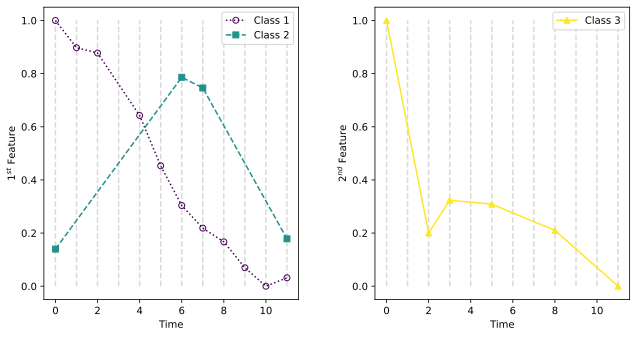

In [8]:
xs = np.arange(12)
fig, ax = plt.subplots(ncols=2)
fig.set_figwidth(9)
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Time')
ax[0].set_ylabel('$1^{st}$ Feature')
ax[1].set_ylabel('$2^{nd}$ Feature')
ax[0].vlines(xs, 0, 1, 'grey', 'dashed', alpha=0.3)
ax[1].vlines(xs, 0, 1, 'grey', 'dashed', alpha=0.3)
for j in range(1, X[0].shape[1]):
    ax[X[0][0,j].astype('int')].plot(X[0][1:,0], X[0][1:,j], 'o:', label='Class 1', color=cmap[0], fillstyle='none')
for j in range(1, X[100].shape[1]):
    ax[X[100][0,j].astype('int')].plot(X[100][1:,0], X[100][1:,j], 's--', label='Class 2', color=cmap[1])
for j in range(1, X[200].shape[1]):
    ax[X[200][0,j].astype('int')].plot(X[200][1:,0], X[200][1:,j], '^-', label='Class 3', color=cmap[2])
ax[0].legend()
ax[1].legend()
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
# plt.savefig('demoMissing.png')

# Model

The model is implemented as an instance of a scikit-learn `estimator` class. It implements interface functions `transform`, `fit_transform`, `predict`, `predict_proba` and `predict_log_proba` according to the specification, and can also be used in the beginning of a scikit-learn `Pipeline` in order to transform irregular tensor data into an `n_samples`$\times$`r` matrix, which can then be further processed using other scikit-learn estimators.

Assume that data is recorded at $T$ timepoints and for $F$ features. Let there be $K$ classes $i=1,2,\ldots,K$ and $j=1,2,\ldots,m_i$ subjects in each class. For each subject, let the timepoints recorded be $t_1, t_2,\ldots,t_{T_{ij}}$ and the features recorded be $f_1,f_2,\ldots,f_{F_{ij}}$. The model can be described as $$Y_{ij}=S_{ij}(\lambda_0 + \Lambda\alpha_i\xi + \gamma_{ij})C_{ij} + \epsilon_{ij}$$
Here $Y_{ij}\in\mathbb{R}^{T_{ij}\times F_{ij}}$ are the data matrices, where each row is a timepoint and each column is a feature. $S_{ij}$s are the spline matrices, formed from the spline basis function set $\{\mathbf{s}_1(t), \mathbf{s}_2(t),\ldots,\mathbf{s}_b(t)\}$. Similar to $Y_{ij}$, the rows are timepoints and the columns are basis functions, so the matrix is defined as $$S_{ij}=\begin{bmatrix}
\mathbf{s}_1(t_1) &\mathbf{s}_2(t_1) &\cdots &\mathbf{s}_b(t_1)\\
\mathbf{s}_1(t_2) &\mathbf{s}_2(t_2) &\cdots &\mathbf{s}_b(t_2)\\
&\vdots\\
\mathbf{s}_1(t_{T_{ij}}) &\mathbf{s}_2(t_{T_{ij}}) &\cdots &\mathbf{s}_b(t_{T_{ij}})\\
\end{bmatrix}$$ $C_{ij}\in\mathbb{R}^{F\times F_{ij}}$ are the $\{f_1^{th}, f_2^{th},\ldots,f_{F_{ij}}^{th}\}$ columns of an $F\times F$ identity matrix, $\lambda_0\in\mathbb{R}^{b\times F}$ is the mean parameter, $\alpha_i\in\mathbb{R}^{r\times r}$s are the reduced rank linear discriminants, $\Lambda\in\mathbb{R}^{b\times r}$ and $\xi\in\mathbb{R}^{r\times F}$ are matrices used to compute the full rank linear discriminants, $\gamma_{ij}\in\mathcal{N}_{b\times F}(0,\Sigma,\Psi)$ is the internal autoregressive noise and $\epsilon_{ij}\sim\mathcal{N}_{T_{ij}\times F_{ij}}(0,\sigma^2I)$ is the measurement noise.
We use an ECM algorithm to fit the model to the data, for computational efficiency.

# Results

## r=2

### Fitting the data

We run the model with the given input data

In [5]:
xs = np.linspace(0, 1, n_t)
fnLibrary = np.array([err + np.log(xs + np.exp(-err)), err * np.exp(-25*(xs - .5)**2), err/(1 + np.exp(-10*(xs - 0.5))), 1/(xs + 1/err), err * (1 - np.exp(-25*(xs - .5)**2)), err/(1 + np.exp(10*(xs - 0.5)))])
ys = fnLibrary[indices].T
mse = np.zeros((10, 4))
for r in range(1, 5):
    for j in tqdm(range(10)):
        X, y = [], []
        for i in range(np.sum(nSubjects)):
            currY = i // 100
            currX = ys[:, currY * nFeatures: (currY + 1) * nFeatures] + arNoise.rvs() + measurementNoise.rvs()
            currX = (currX - currX.mean(0)) / (currX.max(0) - currX.min(0))
            currX -= currX.min(0)
            currX = np.hstack((np.atleast_2d(np.arange(n_t)).T, currX))
            currX = np.vstack((np.hstack((np.nan, np.arange(nFeatures))), currX))
            X.append(currX)
            y.append(currY)
        model = MUDRA(n_iter=500, r=r, nBasis=9).fit(convertToDataFrame(X), y)
        for i in range(model.n_classes):
            estimFns = model.getClassFunctionals(xs, i)
            classCurves = normalize(ys[:,i * model.n_features: (i+1) * model.n_features])
            mse[j, r-1] += np.linalg.norm(classCurves - estimFns)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2fab769850>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2fab76a7e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2fab7684d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f2fab76a240>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2fab769ee0>,
 'means': []}

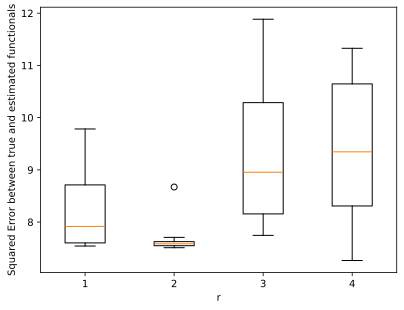

In [6]:
plt.ylabel('Squared Error between true and estimated functionals')
plt.xlabel('r')
plt.boxplot(mse)

### Plot the estimated class functionals

We plot the estimated functionals. Each plot represents one feature, and each colour represents one class.

Let $S$ be the spline basis matrix evaluated at all time points for which any data was recorded. Then the class functionals can simply be estimated as $$Y=S(\lambda_0 + \Lambda\alpha_i\xi)$$, where each column represents one feature functional.

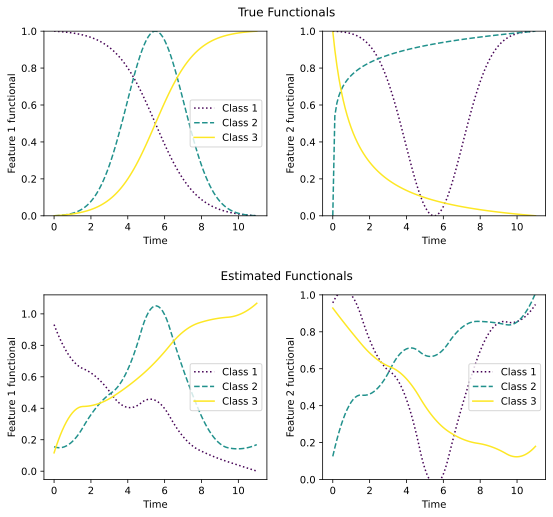

In [56]:
model = MUDRA(n_iter=500, r=2, nBasis=9).fit(convertToDataFrame(X_test), y_test)
xs = np.linspace(0, 1, 100)
fnLibrary = np.array([err + np.log(xs + np.exp(-err)), err * np.exp(-25*(xs - .5)**2), err/(1 + np.exp(-10*(xs - 0.5))), 1/(xs + 1/err), err * (1 - np.exp(-25*(xs - .5)**2)), err/(1 + np.exp(10*(xs - 0.5)))])
ys = fnLibrary[indices].T
xs = np.linspace(model.splineDomain[0], model.splineDomain[1], 100)
fig = plt.figure('Estimated Functionals')
fig.set_figwidth(9)
fig.set_figheight(7)
subFigs = fig.subfigures(nrows=2, hspace=0.1)
subFigs[0].suptitle('True Functionals')
subFigs[1].suptitle('Estimated Functionals')
ax = [subFigs[1].add_subplot(121), subFigs[1].add_subplot(122)]
lineStyles = [':','--','-']
for i in range(model.n_classes):
    fn = model.getClassFunctionals(xs, i)
    className = 'Class ' + str(i+1)
    for j in range(model.n_features):
        ax[j].plot(xs, fn[:,j], lineStyles[i], color=cmap[i], label=className)
    
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Feature 1 functional')
ax[0].legend()
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Feature 2 functional')
ax[1].legend()
ax = [subFigs[0].add_subplot(121), subFigs[0].add_subplot(122)]
ax[0].plot(xs, normalize(ys[:,0]), ':', color=cmap[0], label='Class 1')
ax[1].plot(xs, normalize(ys[:,1]), ':', color=cmap[0], label='Class 1')
ax[0].plot(xs, normalize(ys[:,2]), '--', color=cmap[1], label='Class 2')
ax[1].plot(xs, normalize(ys[:,3]), '--', color=cmap[1], label='Class 2')
ax[0].plot(xs, normalize(ys[:,4]), '-', color=cmap[2], label='Class 3')
ax[1].plot(xs, normalize(ys[:,5]), '-', color=cmap[2], label='Class 3')
ax[0].set_ylim([0, 1])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Feature 1 functional')
ax[0].legend()
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Feature 2 functional')
plt.subplots_adjust(wspace=0.25)

### Dimension Reduction

Let $Y$ be a new datapoint that is not in the training set. Similar to training, we will construct the corresponding $S_Y$ and $C_Y$ matrix. Define $M_Y = \sigma^2I + (C^T\Psi C)\otimes (S\Sigma S^T)$ and $A_Y=(\xi C)^T\otimes(S\Lambda)$. Then, we choose $\hat{\alpha}_Y$ such that $$vec(\hat{\alpha}_Y)=(A_Y^TM_Y^{-1}A_Y)^{-\frac{1}{2}}A_Y^TM_Y^{-1}Y$$ Reshaping into an $r\times r$ matrix and taking the diagonal elements, we arrive at an $r$ dimensional representation of $Y$ that has unit covariance, since $var(vec(Y))=A_Y^TM_Y^{-1}A_Y$.

### Classification

Classification of a sample is done by computing the posterior probabilities of belonging to each class, and then choosing the class with the highest posterior. $$P(\text{class}=i|Y) = \frac{P(Y|\text{class}=i)P(\text{class}=i)}{\sum_{k=1}^KP(Y|\text{class}=k)P(\text{class}=k)}$$ Simplifying this tells us that it is enough to find the class $i$ such that the value of $||\hat{\alpha}_Y - (A_Y^TM_Y^{-1})A)^{\frac{1}{2}}vec(\alpha_i)||_F$ is minimized.

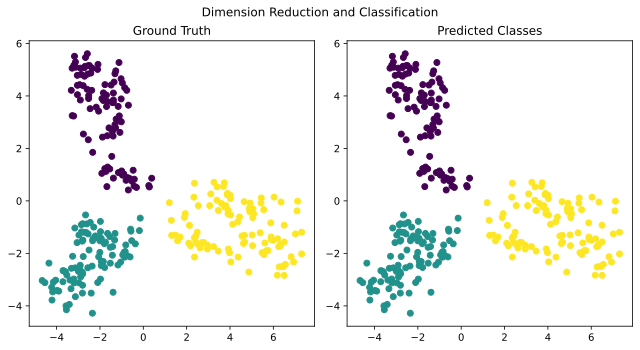

In [11]:
pts = model.transform(convertToDataFrame(X_test))
fig = plt.figure('Dimension Reduction and Classification')
fig.set_figwidth(9)
ax = fig.add_subplot(121)
ax.scatter(pts[:,0], pts[:,3], c=y_test)
ax.set_title('Ground Truth')
ax.set_box_aspect(1)
ax = fig.add_subplot(122)
ax.scatter(pts[:,0], pts[:,3], c=model.predict(convertToDataFrame(X_test)))
ax.set_title('Predicted Classes')
ax.set_box_aspect(1)
fig.suptitle('Dimension Reduction and Classification')
fig.tight_layout()

In [13]:
print(classification_report(y_test, model.predict(convertToDataFrame(X_test))))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



## r=3

### Fitting the data

In [45]:
model = MUDRA(r=3, n_iter=500, nBasis=9).fit(convertToDataFrame(X_test), y_test)
pts = model.transform(convertToDataFrame(X))

### Plot the estimated class functionals

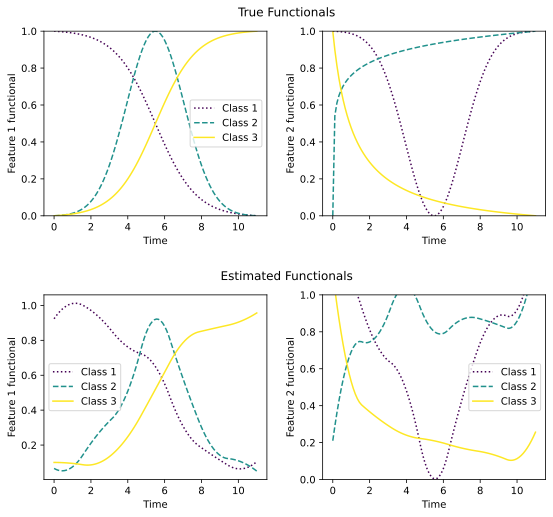

In [55]:
xs = np.linspace(0, 1, 100)
fnLibrary = np.array([err + np.log(xs + np.exp(-err)), err * np.exp(-25*(xs - .5)**2), err/(1 + np.exp(-10*(xs - 0.5))), 1/(xs + 1/err), err * (1 - np.exp(-25*(xs - .5)**2)), err/(1 + np.exp(10*(xs - 0.5)))])
ys = fnLibrary[indices].T
xs = np.linspace(model.splineDomain[0], model.splineDomain[1], 100)
fig = plt.figure('Estimated Functionals')
fig.set_figwidth(9)
fig.set_figheight(7)
subFigs = fig.subfigures(nrows=2, hspace=0.1)
subFigs[0].suptitle('True Functionals')
subFigs[1].suptitle('Estimated Functionals')
ax = [subFigs[1].add_subplot(121), subFigs[1].add_subplot(122)]
lineStyles = [':','--','-']
for i in range(model.n_classes):
    fn = model.getClassFunctionals(xs, i)
    className = 'Class ' + str(i+1)
    for j in range(model.n_features):
        ax[j].plot(xs, fn[:,j], lineStyles[i], color=cmap[i], label=className)
    
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Feature 1 functional')
ax[0].legend()
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Feature 2 functional')
ax[1].legend()
ax = [subFigs[0].add_subplot(121), subFigs[0].add_subplot(122)]
ax[0].plot(xs, normalize(ys[:,0]), ':', color=cmap[0], label='Class 1')
ax[1].plot(xs, normalize(ys[:,1]), ':', color=cmap[0], label='Class 1')
ax[0].plot(xs, normalize(ys[:,2]), '--', color=cmap[1], label='Class 2')
ax[1].plot(xs, normalize(ys[:,3]), '--', color=cmap[1], label='Class 2')
ax[0].plot(xs, normalize(ys[:,4]), '-', color=cmap[2], label='Class 3')
ax[1].plot(xs, normalize(ys[:,5]), '-', color=cmap[2], label='Class 3')
ax[0].set_ylim([0, 1])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Feature 1 functional')
ax[0].legend()
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Feature 2 functional')
plt.subplots_adjust(wspace=0.25)

### Cluster plots

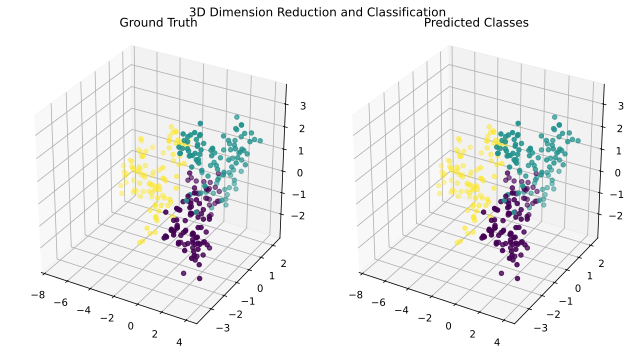

In [47]:
fig = plt.figure('3D Dimension Reduction and Classification')
fig.set_figwidth(9)
ax = fig.add_subplot(121, projection='3d')
ax.scatter(pts[:,0], pts[:,1], pts[:,2], c=y_test)
ax.set_title('Ground Truth')
ax.set_box_aspect((1, 1, 1))
ax = fig.add_subplot(122, projection='3d')
ax.scatter(pts[:,0], pts[:,1], pts[:,2], c=model.predict(convertToDataFrame(X_test)))
ax.set_title('Predicted Classes')
ax.set_box_aspect((1, 1, 1))
fig.suptitle('3D Dimension Reduction and Classification')
fig.tight_layout()

In [48]:
print(classification_report(y_test, model.predict(convertToDataFrame(X_test))))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

